Guassian Process for more complex model, 多维输入
---

In [1]:
import pymc3 as pm
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import theano.tensor as tt
from theano import shared
import pandas as pd
from matplotlib import gridspec
%matplotlib inline

import scipy as sp
from theano.compile.ops import as_op
from numpy import arange, array, empty
from Plot_raw import *

D:\Softwares\Python\Python_Anaconda\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


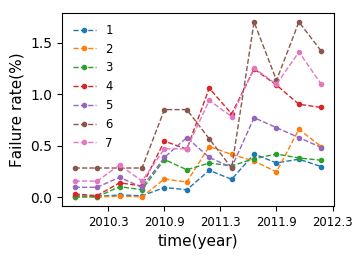

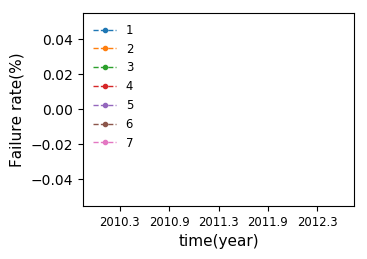

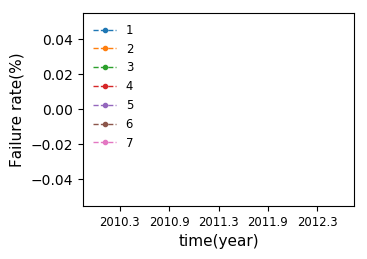

In [2]:
np.set_printoptions(precision=0, suppress=True)
Savefig = 0 # 控制图形显示存储
plt.style.use('default')
elec_data = pd.read_csv('XZnozero_12C.csv')

# 计算同一公司产品测试地点数目：
companies_num = elec_data.counts.unique()
companies = len(companies_num)  # companies=7， 共7个测试地点
company_lookup = dict(zip(companies_num, range(len(companies_num))))
company = elec_data['company_code'] = elec_data.counts.replace(company_lookup).values  # 加一行数据在XZsingal文件中

# 计算不同公司数目
company_ABC = elec_data.company.unique()
companiesABC = len(company_ABC)  # companies=7， 共7个测试地点
company_lookup_ABC = dict(zip(company_ABC, range(len(company_ABC))))
companyABC = elec_data['company_ABC'] = elec_data.company.replace(company_lookup_ABC).values  # 加一行数据在XZsingal文件中

# 给所有特征因素加上高斯噪声
SNR = np.random.normal(0, 1, size=[len(elec_data.Year.values), 3])

# #特征因素分析
elec_tem = elec_data.Tem.values # 观测温度值x2，温度不加噪声
elec_tem1 = (elec_tem - np.mean(elec_tem)) / np.std(elec_tem)
elec_hPa = elec_data.hPa.values + SNR[:, 0]  # 观测压强x3
elec_hPa1 = (elec_hPa - np.mean(elec_hPa)) / np.std(elec_hPa)
elec_RH = elec_data.RH.values + SNR[:, 1] # 观测压强x3
elec_RH1 = (elec_RH - np.mean(elec_RH)) / np.std(elec_RH)
elec_Lux = elec_data.Lux.values + SNR[:, 2] # 观测压强x3
elec_Lux1 = (elec_Lux - np.mean(elec_Lux)) / np.std(elec_Lux)

# 计算观测时间，温度，光照等环境条件
elec_year = elec_data.Year.values  # 观测时间值x1
elec_year1 = (elec_year - np.mean(elec_year)) / np.std(elec_year)
data_cs_year = elec_year[:,None] #必须要这种形式才行

# 计算故障率大小：故障数目/总测量数，作为模型Y值，放大100倍以增加实际效果，结果中要缩小100倍
elec_faults = 100*(elec_data.Fault.values / elec_data.Nums.values)  # 数组形式,计算故障率大小
# elec_faults[1] = 1.6
# print(elec_faults)
 
# 将故障率以6组一行形式组成数组,变成：21*6
elec_faults2 = np.array([elec_faults[i*12:(i+1)*12] for i in np.arange(21)])
elec_year2 = np.array([elec_year[i*12:(i+1)*12] for i in np.arange(21)])
companyABC2 = np.array([companyABC[i*12:(i+1)*12] for i in np.arange(21)])
# elec_faults2 = np.ma.masked_values(elec_faults2, value=1000)

Plot_raw(elec_year2, elec_faults2, Savefig)
# 共享变量设置

ys_faultsA = shared(np.asarray(elec_faults[:84]))
# ys_faultsB = shared(np.asarray(elec_faults[84:168]))
# ys_faultsC = shared(np.asarray(elec_faults[168:]))

xs_yearA = shared(np.asarray(elec_year[:84]))
# xs_yearB = shared(np.asarray(elec_year[84:168]))
# xs_yearC = shared(np.asarray(elec_year[168:]))
# Num_shared = shared(np.asarray(companyABC))

def logit(x):
    return 1/(1+np.exp(-x))
def Invlogit(x):
    return tt.exp(x)/(1+tt.exp(x))

In [13]:
change= np.array([0 for i in np.arange(len(elec_year))])

bbb = elec_year[:, None]
ccc = elec_tem1[:, None]
ddd = elec_hPa1[:, None]

aaa = np.hstack((bbb, ccc, ddd))
print(aaa)

y = elec_faults
# print(aaa[:,1])

[[ 1. -0. -1.]
 [ 2.  0. -2.]
 [ 3. -1.  1.]
 [ 4.  0. -0.]
 [ 5. -1. -0.]
 [ 6.  1.  1.]
 [ 7. -0.  0.]
 [ 8.  1. -1.]
 [ 9. -1.  1.]
 [10. -0.  0.]
 [11. -2.  2.]
 [12.  1. -0.]
 [ 1. -0. -1.]
 [ 2.  0. -1.]
 [ 3. -1.  1.]
 [ 4.  0. -1.]
 [ 5. -1. -0.]
 [ 6.  1.  1.]
 [ 7. -0. -1.]
 [ 8.  1. -1.]
 [ 9. -1. -1.]
 [10. -0. -1.]
 [11. -2.  0.]
 [12.  1. -0.]
 [ 1. -0. -0.]
 [ 2.  0. -1.]
 [ 3. -1. -0.]
 [ 4.  0. -1.]
 [ 5. -1. -2.]
 [ 6.  1.  2.]
 [ 7. -0.  0.]
 [ 8.  1.  2.]
 [ 9. -1.  1.]
 [10. -0. -0.]
 [11. -2.  1.]
 [12.  1.  0.]
 [ 1. -0. -1.]
 [ 2.  0. -0.]
 [ 3. -1. -1.]
 [ 4.  0. -0.]
 [ 5. -1.  2.]
 [ 6.  1.  1.]
 [ 7. -0. -0.]
 [ 8.  1. -1.]
 [ 9. -1.  1.]
 [10. -0.  0.]
 [11. -2.  0.]
 [12.  1. -0.]
 [ 1. -0.  1.]
 [ 2.  0. -0.]
 [ 3. -1.  1.]
 [ 4.  0. -0.]
 [ 5. -1. -1.]
 [ 6.  1. -0.]
 [ 7. -0. -0.]
 [ 8.  1.  1.]
 [ 9. -1. -3.]
 [10. -0.  0.]
 [11. -2.  0.]
 [12.  1. -0.]
 [ 1. -0. -1.]
 [ 2.  0.  1.]
 [ 3. -1.  1.]
 [ 4.  0.  0.]
 [ 5. -1.  2.]
 [ 6.  1.  1.]
 [ 7. -0. 

In [14]:
with pm.Model() as model:
    η_per = pm.HalfCauchy("η_per", beta=2)
    ℓ_pdecay = pm.Gamma("ℓ_pdecay", alpha=10, beta=0.075)
    period  = pm.Normal("period", mu=2, sd=0.05) # 周期必须是2
    ℓ_psmooth = pm.Gamma("ℓ_psmooth ", alpha=4, beta=3)
    cov_seasonal = η_per**2 * pm.gp.cov.Periodic(1, period, ℓ_psmooth) \
                            * pm.gp.cov.Matern52(1, ℓ_pdecay)
    gp_seasonal = pm.gp.Marginal(mean_func =pm.gp.mean.Constant(1) , cov_func=cov_seasonal)

    # small/medium term irregularities
    η_med = pm.HalfCauchy("η_med", beta=0.5)
    ℓ_med = pm.Gamma("ℓ_med", alpha=2, beta=0.75)
    α = pm.Gamma("α", alpha=5, beta=2)
    cov_medium = η_med**2 * pm.gp.cov.RatQuad(3, ℓ_med, α)
    gp_medium = pm.gp.Marginal(mean_func =pm.gp.mean.Constant(1) ,cov_func=cov_medium)
    
    # long term trend
    η_trend = pm.HalfCauchy("η_trend", beta=1)
    ℓ_trend = pm.Gamma("ℓ_trend", alpha=4, beta=0.1)
    cov_trend = η_trend**2 * pm.gp.cov.ExpQuad(3, ℓ_trend)
    gp_trend = pm.gp.Marginal(mean_func =pm.gp.mean.Constant(1) ,cov_func=cov_trend) 
    
    gp = gp_seasonal + gp_trend + gp_medium

    δ = pm.HalfCauchy("δ", 5)
    # noise model
#     η_noise = pm.HalfNormal("η_noise", sd=0.5)
#     ℓ_noise = pm.Gamma("ℓ_noise", alpha=2, beta=4)
#     σ  = pm.HalfNormal("σ",  sd=0.25)
#     cov_noise = η_noise**2 * pm.gp.cov.Matern32(1, ℓ_noise) +\
#                 pm.gp.cov.WhiteNoise(σ)
        
    y_ = gp.marginal_likelihood("y", X=aaa, y=elec_faults, noise=δ)
    
    mp = pm.find_MAP(include_transformed=True)
    trace = pm.sample(1000, start=mp)

logp = -42.537, ||grad|| = 0.0026125: 100%|████████████████████████████████████████████| 65/65 [00:00<00:00, 97.34it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
100%|█████████████████████████████████████████████████████████████████████████████▉| 1499/1500 [02:34<00:00,  9.73it/s]D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\step_methods\hmc\nuts.py:467: UserWarning: Chain 0 contains 7 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
100%|██████████████████████████████████████████████████████████████████████████████| 1500/1500 [02:34<00:00,  9.73it/s]


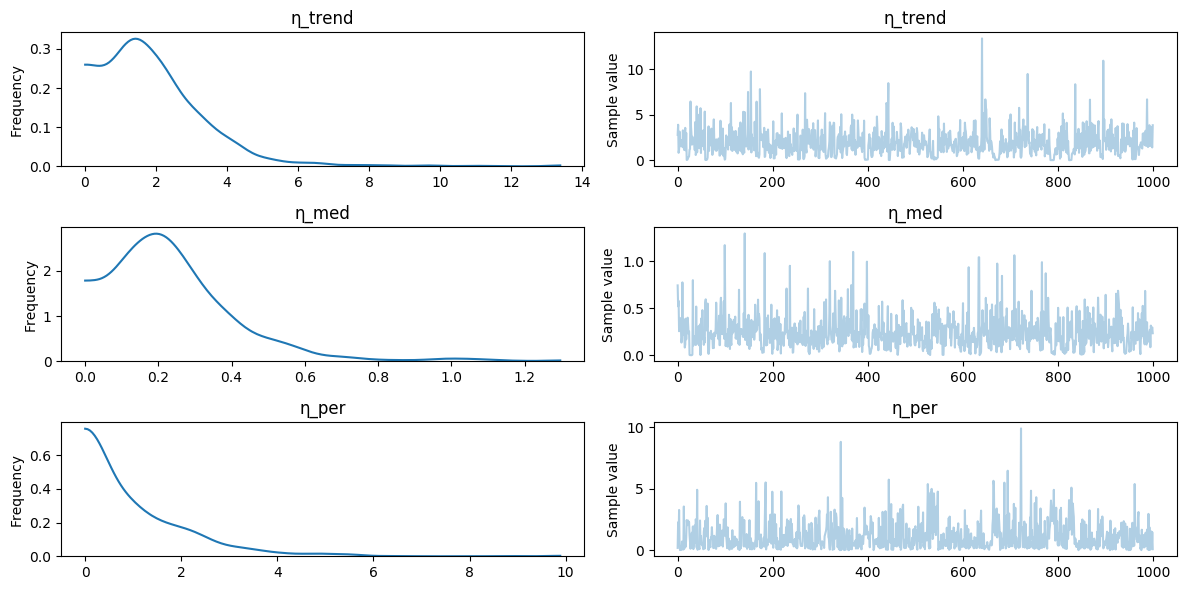

In [16]:
pm.traceplot(trace, ["η_trend", "η_med", "η_per"])
plt.show()

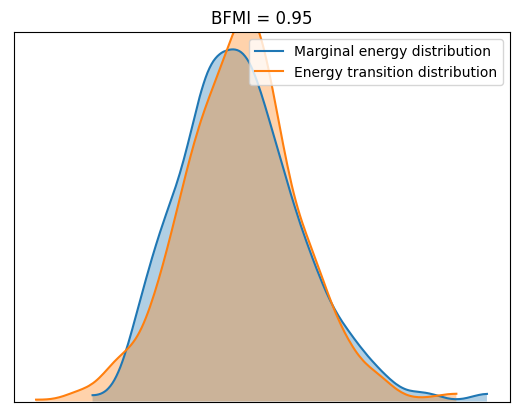

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\stats.py:220: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)


DIC:  WAIC_r(WAIC=64.7892040137834, WAIC_se=0.0, p_WAIC=2.2163179014731136)


In [17]:
ax = pm.energyplot(trace)
bfmi = pm.bfmi(trace)
ax.set_title(f"BFMI = {bfmi:.2f}");
plt.show()
WAIC = pm.waic(trace=trace, model=model)
print('DIC: ',WAIC)

In [23]:
# new values from x=0 to x=20
X_new = aaa
New_x = np.linspace(0.5, 20, 100)[:,None]

New_tem = ccc
New_tem_len = np.concatenate((New_tem, New_tem))
New_hPa = ddd
New_hPa_len = np.concatenate((New_hPa, New_hPa))
print(len(New_tem_len))
print(len(ccc))
X_new = np.hstack((New_x, New_tem_len[:100], New_hPa_len[:100]))
print(len(X_new))
print(X_new)

168
84
100
[[ 0. -0. -1.]
 [ 1.  0. -2.]
 [ 1. -1.  1.]
 [ 1.  0. -0.]
 [ 1. -1. -0.]
 [ 1.  1.  1.]
 [ 2. -0.  0.]
 [ 2.  1. -1.]
 [ 2. -1.  1.]
 [ 2. -0.  0.]
 [ 2. -2.  2.]
 [ 3.  1. -0.]
 [ 3. -0. -1.]
 [ 3.  0. -1.]
 [ 3. -1.  1.]
 [ 3.  0. -1.]
 [ 4. -1. -0.]
 [ 4.  1.  1.]
 [ 4. -0. -1.]
 [ 4.  1. -1.]
 [ 4. -1. -1.]
 [ 5. -0. -1.]
 [ 5. -2.  0.]
 [ 5.  1. -0.]
 [ 5. -0. -0.]
 [ 5.  0. -1.]
 [ 6. -1. -0.]
 [ 6.  0. -1.]
 [ 6. -1. -2.]
 [ 6.  1.  2.]
 [ 6. -0.  0.]
 [ 7.  1.  2.]
 [ 7. -1.  1.]
 [ 7. -0. -0.]
 [ 7. -2.  1.]
 [ 7.  1.  0.]
 [ 8. -0. -1.]
 [ 8.  0. -0.]
 [ 8. -1. -1.]
 [ 8.  0. -0.]
 [ 8. -1.  2.]
 [ 9.  1.  1.]
 [ 9. -0. -0.]
 [ 9.  1. -1.]
 [ 9. -1.  1.]
 [ 9. -0.  0.]
 [10. -2.  0.]
 [10.  1. -0.]
 [10. -0.  1.]
 [10.  0. -0.]
 [10. -1.  1.]
 [11.  0. -0.]
 [11. -1. -1.]
 [11.  1. -0.]
 [11. -0. -0.]
 [11.  1.  1.]
 [12. -1. -3.]
 [12. -0.  0.]
 [12. -2.  0.]
 [12.  1. -0.]
 [12. -0. -1.]
 [13.  0.  1.]
 [13. -1.  1.]
 [13.  0.  0.]
 [13. -1.  2.]
 [13.  1.  1.]

In [24]:
#预测
# add the GP conditional to the model, given the new X values
with model:
    f_pred1 = gp.conditional("f_pred1", X_new)

# To use the MAP values, you can just replace the trace with a length-1 list with `mp`
with model:
    pred_samples = pm.sample_ppc([mp], vars=[f_pred1], samples=2000)

# Sample from the GP conditional distribution
with model:
    pred_samples1 = pm.sample_ppc(trace, vars=[f_pred1], samples=1000)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:27<00:00, 36.89it/s]


In [26]:
low, high = np.percentile(pred_samples1['f_pred1'], [5, 95], axis=0)
for i in np.arange(len(low)):
    if low[i]<0:
        low[i]=0
predf_pred = pred_samples1['f_pred1']
f_pred_mean = predf_pred.mean(axis=0)

#这条语句是为了画图用
X_new1 = X_new
# np.linspace(0.5, 20, 100)
print(low)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


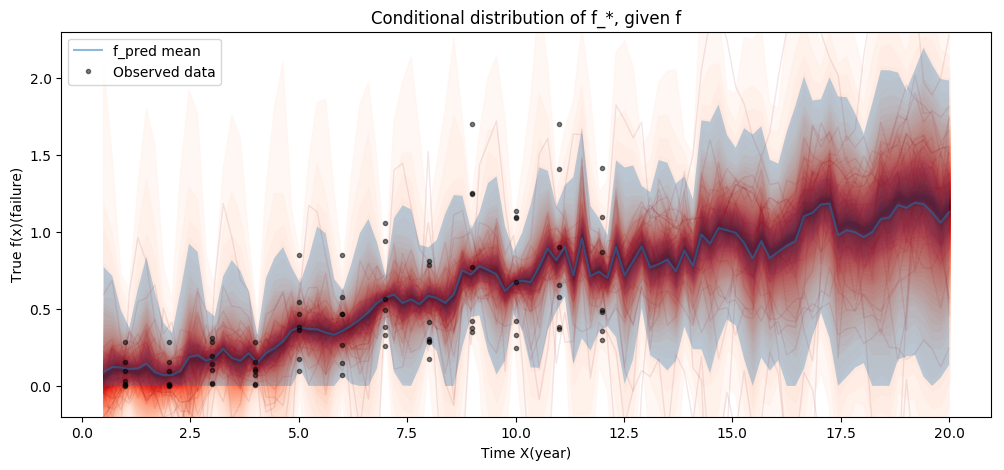

In [27]:
# plot the results
X = data_cs_year
y = elec_faults
from pymc3.gp.util import plot_gp_dist
fig = plt.figure(figsize=(12,5)); ax = fig.gca()
plot_gp_dist(ax, pred_samples1["f_pred1"], X_new[:,0]);

plt.plot(X_new[:,0], f_pred_mean, alpha=0.5, label="f_pred mean");
plt.fill_between(X_new1[:,0], low, high,  alpha=0.3)
# plt.plot(X, f_true, "dodgerblue", lw=3, label="True f");
plt.plot(X, elec_faults, 'ok', ms=3, alpha=0.5, label="Observed data");
plt.xlabel("Time X(year)");
plt.ylabel("True f(x)(failure)");
plt.ylim(-0.2, 2.3)
plt.title("Conditional distribution of f_*, given f"); plt.legend();
# plt.savefig('E:\\Code\\Bayescode\\QW_reliable\\GP\\Picture\\Fitting0.png', dpi = 200, bbox_inches='tight')

KeyError: 'f_pred'

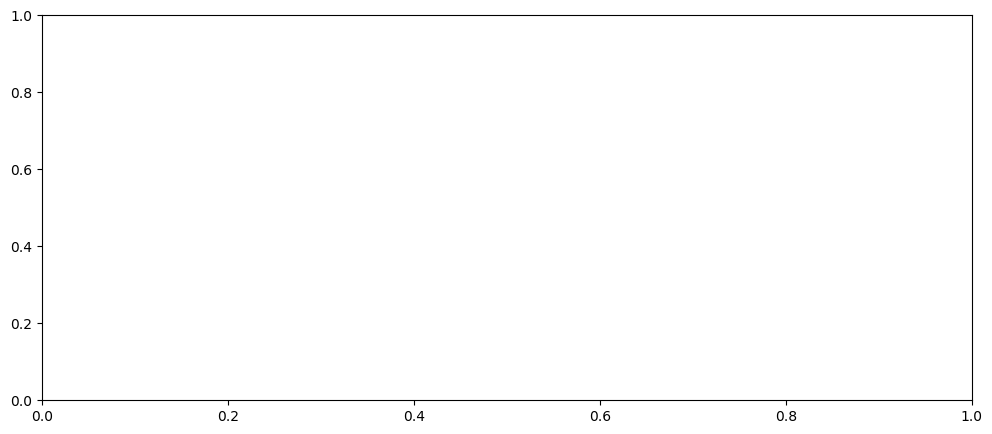

In [28]:
# 画图
X = data_cs_year
y = elec_faults
# plot the results
fig = plt.figure(figsize=(12,5)); ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
from pymc3.gp.util import plot_gp_dist
plot_gp_dist(ax, pred_samples["f_pred"], X_new);

# plot the data and the true latent function
# plt.plot(X, f_true, "dodgerblue", lw=3, label="True f");
plt.plot(X, elec_faults, 'ok', ms=4, alpha=0.5, label="Observed data");

# axis labels and title
plt.xlabel("Time(year)");
plt.ylabel("Fault rate(%)");
plt.title("Posterior distribution over $f(x)$ at the observed values"); plt.legend()


In [ ]:
# predict
mu, var = gp.predict(X_new, point=mp, diag=True)
sd = np.sqrt(var)

# draw plot
fig = plt.figure(figsize=(12,5)); ax = fig.gca()

# plot mean and 2σ intervals
plt.plot(X_new, mu, 'r', lw=2, label="mean and 2σ region");
plt.plot(X_new, mu + 2*sd, 'r', lw=1); plt.plot(X_new, mu - 2*sd, 'r', lw=1);
plt.fill_between(X_new.flatten(), mu - 2*sd, mu + 2*sd, color="r", alpha=0.5)

# plot original data and true function
plt.plot(X, y, 'ok', ms=4, alpha=1.0, label="observed data");

plt.xlabel("x");
plt.ylabel("Fault rate(%)");
plt.title("predictive mean and 2σ interval");
plt.legend()